In [41]:
from wilds.datasets.camelyon17_dataset import Camelyon17Dataset
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper
from utils import load
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from models.layers import Identity


In [138]:
config =  {
        'split_scheme': 'official',
        'model': 'densenet121',
        'model_kwargs': {'pretrained': False},
        'train_transform': 'image_base',
        'eval_transform': 'image_base',
        'target_resolution': (96, 96),
        'loss_function': 'cross_entropy',
        'groupby_fields': ['hospital'],
        'val_metric': 'acc_avg',
        'val_metric_decreasing': False,
        'optimizer': 'SGD',
        'optimizer_kwargs': {'momentum': 0.9},
        'scheduler': None,
        'batch_size': 32,
        'lr': 0.001,
        'weight_decay': 0.01,
        'n_epochs': 5,
        'n_groups_per_batch': 2,
        'irm_lambda': 1.0,
        'coral_penalty_weight': 0.1,
        'algo_log_metric': 'accuracy',
        'process_outputs_function': 'multiclass_logits_to_pred',
    }
def initialize_torchvision_model(name, d_out, **kwargs):
    # get constructor and last layer names
    if name == 'wideresnet50':
        constructor_name = 'wide_resnet50_2'
        last_layer_name = 'fc'
    elif name == 'densenet121':
        constructor_name = name
        last_layer_name = 'classifier'
    elif name in ('resnet50', 'resnet34'):
        constructor_name = name
        last_layer_name = 'fc'
    else:
        raise ValueError(f'Torchvision model {name} not recognized')
    # construct the default model, which has the default last layer
    constructor = getattr(torchvision.models, constructor_name)
    model = constructor(**kwargs)
    # adjust the last layer
    d_features = getattr(model, last_layer_name).in_features
    if d_out is None:  # want to initialize a featurizer model
        last_layer = Identity(d_features)
        model.d_out = d_features
    else: # want to initialize a classifier for a particular num_classes
        last_layer = nn.Linear(d_features, d_out)
        model.d_out = d_out
    setattr(model, last_layer_name, last_layer)
    return model

def initialize_image_base_transform(config, dataset):
    transform_steps = []
    if dataset.original_resolution is not None and min(dataset.original_resolution)!=max(dataset.original_resolution):
        crop_size = min(dataset.original_resolution)
        transform_steps.append(transforms.CenterCrop(crop_size))
    if config['target_resolution'] is not None:
        transform_steps.append(transforms.Resize(config['target_resolution']))
    transform_steps += [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    transform = transforms.Compose(transform_steps)
    return transform

class Camelyon_model(nn.Module):
    def __init__(self, featurizer, classifier):
        super().__init__()
        self.model = torch.nn.Sequential(featurizer, classifier)
        self.featurizer = featurizer
        self.classifier = classifier
        
class Camelyon_model_old(nn.Module):
    def __init__(self, featurizer):
        super().__init__()
#         self.model = torch.nn.Sequential(featurizer, classifier)
        self.model = featurizer
#         self.classifier = classifier

In [6]:
dataset = Camelyon17Dataset(root_dir="/data/wilds/data")

In [9]:
train_grouper = CombinatorialGrouper(
        dataset=dataset,
        groupby_fields=['hospital'])

In [70]:
transform = initialize_image_base_transform(config, dataset)
train_data = dataset.get_subset('train', transform=transform, frac=0.1)
val_data = dataset.get_subset('val', transform=transform, frac=0.1)
test_data = dataset.get_subset('test', transform=transform, frac=0.1)

In [71]:
train_loader = get_train_loader('group', train_data, grouper=train_grouper, batch_size=15, n_groups_per_batch=3)
val_loader = get_eval_loader('standard', val_data, grouper=train_grouper, batch_size=5)
test_loader = get_eval_loader('standard', test_data, grouper=train_grouper, batch_size=5)


In [55]:
# get_eval_loader('group', val_data, grouper=train_grouper, batch_size=16)

In [116]:
ckpt = torch.load('/data/wilds/log_camelyon17_gropu/best_model.pth')

In [32]:
model_states = {}
for k in ckpt['algorithm'].keys():
    model_states[k.replace("model.0.","")] = ckpt['algorithm'][k]

In [ ]:
ckpt['algorithm'].keys()

In [ ]:
featurizer

In [192]:
# featurizer = initialize_torchvision_model('densenet121', d_out=None)
# classifier = nn.Linear(featurizer.d_out, 2)
# model = (featurizer, classifier)
#model = Camelyon_model(featurizer, classifier)

featurizer = initialize_torchvision_model('densenet121', d_out=2)
model = Camelyon_model_old(featurizer)

In [193]:
model.load_state_dict(ckpt['algorithm'], strict=False)


<All keys matched successfully>

In [194]:
last = torch.nn.Sequential(*(list(model.model.children())[-1:]))
model = torch.nn.Sequential(*(list(model.model.children())[:-1]))

In [177]:
model

Sequential(
  (0): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): R

In [154]:
model.to('cuda:1')
model.eval()
group_list = []
hidden_list = []
count = 0
with torch.no_grad():
    for b in train_loader:
        inputs, y, group = b
        inputs = inputs.to('cuda:1')
#         outputs = model(inputs)
        groups = train_grouper.metadata_to_group(group)
#         features = model.featurizer(inputs)
        features = model(inputs)
        group_list.extend(groups)
        hidden_list.extend(features.cpu().numpy())
        count += 1
#         break
        if count == 20:
            break

count = 0
with torch.no_grad():
    for b in val_loader:
        inputs, y, group = b
        inputs = inputs.to('cuda:1')
#         outputs = model(inputs)
        groups = train_grouper.metadata_to_group(group)
#         features = model.featurizer(inputs)
        features = model(inputs)
        group_list.extend(groups)
        hidden_list.extend(features.cpu().numpy())
        count += 1
#         break
        if count == 20:
            break

count = 0
with torch.no_grad():
    for b in test_loader:
        inputs, y, group = b
        inputs = inputs.to('cuda:1')
#         outputs = model(inputs)
        groups = train_grouper.metadata_to_group(group)
#         features = model.featurizer(inputs)
        features = model(inputs)
        group_list.extend(groups)
        hidden_list.extend(features.cpu().numpy())
        count += 1
#         break
        if count == 20:
            break

In [155]:
X = np.array(hidden_list)
y = np.array(group_list)
IND = (y==0) | (y==3) | (y==4)
OOD = (y==2) | (y==1)
INDOOD = (y!=1) 
# OOD = (y==2) 

In [196]:
model.to('cuda:1')
last.to('cuda:1')
last(model(inputs))

RuntimeError: mat1 dim 1 must match mat2 dim 0

In [156]:
from yellowbrick.text import TSNEVisualizer
import numpy as np
X = np.array(hidden_list)
y = np.array(group_list)

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X[IND], y[IND])
tsne.show()

ValueError: Found array with dim 4. Estimator expected <= 2.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


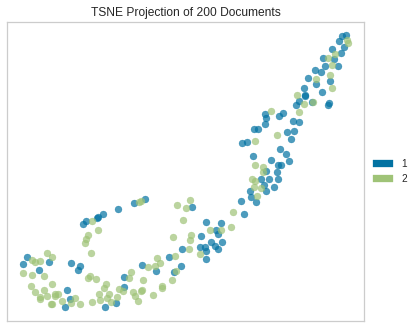

<AxesSubplot:title={'center':'TSNE Projection of 200 Documents'}>

In [108]:
tsne = TSNEVisualizer()
tsne.fit(X[OOD], y[OOD])
tsne.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

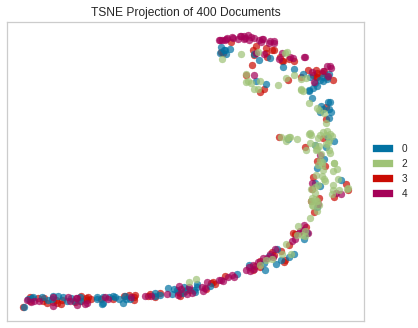

<AxesSubplot:title={'center':'TSNE Projection of 400 Documents'}>

In [115]:
tsne = TSNEVisualizer()
tsne.fit(X[INDOOD], y[INDOOD])
tsne.show()

In [152]:
X[0].shape

(1024,)

In [90]:
y[1600]

1

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


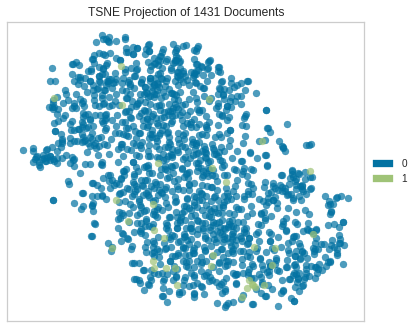

<AxesSubplot:title={'center':'TSNE Projection of 1431 Documents'}>

In [19]:
X = np.array(hidden_list)
y = np.array(group_list)

black = (y==0) | (y==1)
X_b = X[black]
y_b = y[black]
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X_b, y_b)
tsne.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


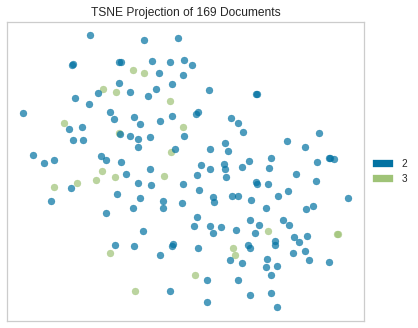

<AxesSubplot:title={'center':'TSNE Projection of 169 Documents'}>

In [20]:
X = np.array(hidden_list)
y = np.array(group_list)

black = (y==2) | (y==3)
X_b = X[black]
y_b = y[black]
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X_b, y_b)
tsne.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


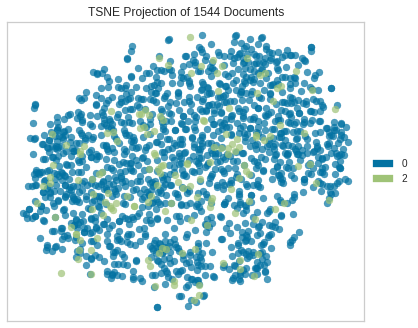

<AxesSubplot:title={'center':'TSNE Projection of 1544 Documents'}>

In [21]:
X = np.array(hidden_list)
y = np.array(group_list)

black = (y==0) | (y==2)
X_b = X[black]
y_b = y[black]
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X_b, y_b)
tsne.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


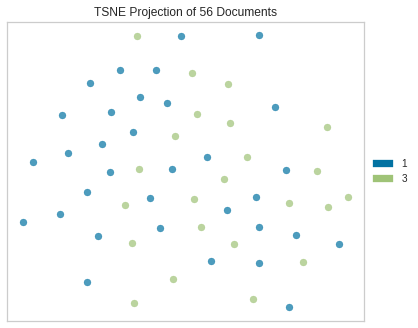

<AxesSubplot:title={'center':'TSNE Projection of 56 Documents'}>

In [22]:
X = np.array(hidden_list)
y = np.array(group_list)

black = (y==1) | (y==3)
X_b = X[black]
y_b = y[black]
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X_b, y_b)
tsne.show()

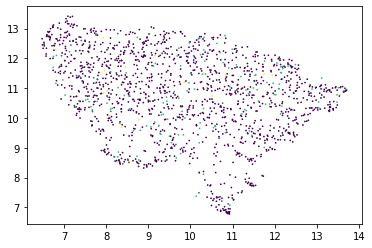

In [17]:
import umap
from matplotlib import pyplot as plt
import numpy as np
X = np.array(hidden_list)
y = np.array(group_list)
# black = (y==1) | (y==3)
# X_b = X[black]
# y_b = y[black]

standard_embedding = umap.UMAP(random_state=42).fit_transform(X)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y.astype(int), s=0.5)


test editing from Han

succeed! LOL